Starter EDA and ConvNet implementation using Keras. 

Inspiration for this notebook comes from this [Keras blog post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) and the [VGG ConvNet paper](https://arxiv.org/pdf/1409.1556.pdf). 


In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Preparing the Data

This function resizes the images to 64x64 and samples 2000 images (8%) of the data to run efficiently as a Kaggle Kernel. I also separated cats and dogs for exploratory analysis. 

In [2]:
TRAIN_DIR = '../data/DogVCat/train/'
TEST_DIR = '../data/DogVCat/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:1000] + train_cats[:1000]
random.shuffle(train_images)
test_images =  test_images[:100]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)#图像的扩大


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Processed 0 of 100
Train shape: (2000, 64, 64, 3)
Test shape: (100, 64, 64, 3)


### Generating the Labels

We're dealing with a binary classification problem here - (1) dog (0) cat. The lables can be created by looping over the file names in the train directory. It's nice to see the training data is perfectly balanced. 

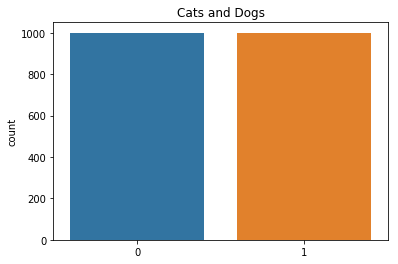

In [3]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
plt.title('Cats and Dogs')

In [27]:
y_test = []
for i in test_images:
    if 'dog' in i:
        y_test.append(1)
    else:
        y_test.append(0)

### Checking out Cats and Dogs
A quick side-by-side comparison of the animals.

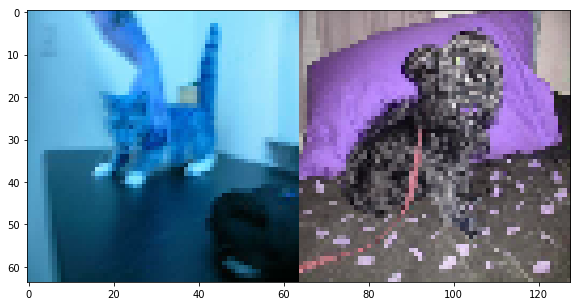

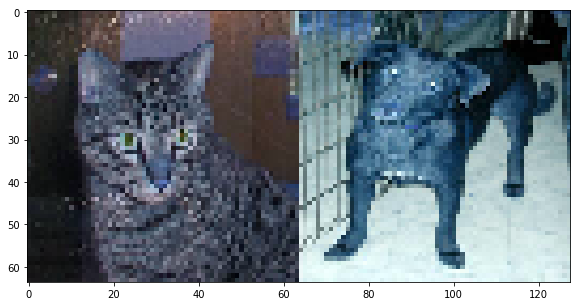

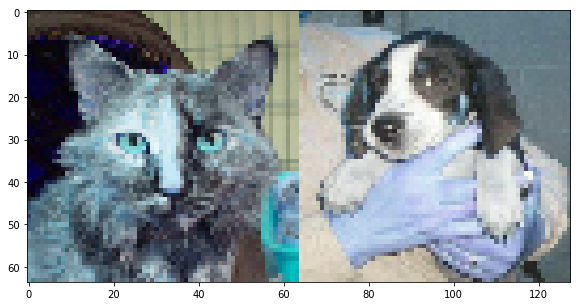

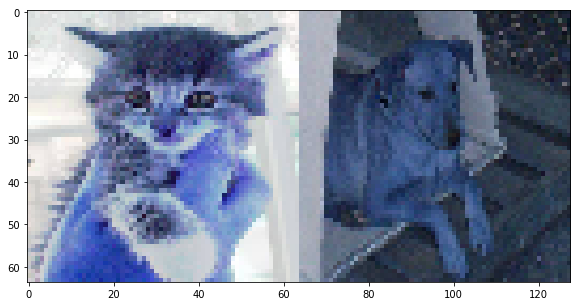

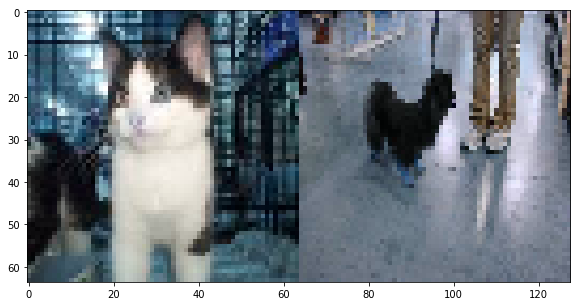

In [4]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

### Your Average Cat and Dog Photo

Just for fun, the mean pixel values for cats and dogs. I can almost see a resemblance, a ghost, if you will...

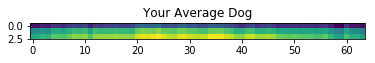

In [5]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)
plt.imshow(dog_avg)
plt.title('Your Average Dog')

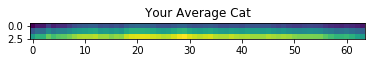

In [6]:
cat_avg = np.array([cat[0].T for i, cat in enumerate(train) if labels[i]==0]).mean(axis=0)
plt.imshow(cat_avg)
plt.title('Your Average Cat')

## CatdogNet-16

A scaled down version of the VGG-16, with a few notable changes.

- Number of convolution filters cut in half, fully connected (dense) layers scaled down. 
- Optimizer changed to `RMSprop`. 
- Output layer activation set to `sigmoid` for binary crossentropy. 
- Some layers commented out for efficiency.

The full network takes about 80s per epoch on a GTX1070 (or 2hr+ on CPU) on the full dataset.  (This script only trains on 8% of the 25K images. )

In [76]:
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras import regularizers

optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()
    model.add(Convolution2D(32, 2, 2, border_mode='same', input_shape=(ROWS, COLS, 3), activation='relu'))
    model.add(Convolution2D(32, 2, 2, border_mode='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), name='block1_pool1', data_format='channels_last'))
    model.add(BatchNormalization())

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), name='block1_pool2', data_format='channels_last'))
    model.add(BatchNormalization())
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), name='block1_pool3', data_format='channels_last'))
    model.add(BatchNormalization())
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), name='block1_pool4', data_format='channels_last'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    optimizer = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    # model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


model = catdog()

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), input_shape=(64, 64, 3..., activation="relu", padding="same")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), activation="relu", padding="same")`
  del sys.path[0]
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the 

In [77]:
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard
plot_model(model, to_file='model.png',show_shapes=True)

In [78]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 64, 64, 32)        416       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 64, 64, 32)        4128      
_________________________________________________________________
block1_pool1 (MaxPooling2D)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool2 (MaxPooling2D)  (None, 16, 16, 64)        0         
__________

### Train and Predict

I'm using Keras's early stopping callback to end training when the validation loss stops improving, otherwise the model will overfit. I will also be tracking the loss history on each epoch to visualize the overfitting trend. 

Note: A slice of 1000 images was used to fit the model for CPU efficency. The model's perfrmance improves significantly when used on the entire dataset. 

In [79]:
nb_epoch = 5
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
##
#1. monitor：需要监视的量
#2. patience：当early stop被激活（如发现loss相比上一个epoch训练没有下降），则经过patience个epoch后停止训练。
#3. verbose：信息展示模式
#4. mode：‘auto’，‘min’，‘max’之一，在min模式下，如果检测值停止下降则中止训练。在max模式下，当检测值不再上升则停止训练。
lrate = ReduceLROnPlateau(min_lr=0.00001)
tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)  # 在当前目录新建logs文件夹，记录 evens.out
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping, tb])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1500 samples, validate on 500 samples
Epoch 1/5
1500/1500 [==============================] - 103s 68ms/step - loss: 8.2752 - acc: 0.5167 - val_loss: 8.0741 - val_acc: 0.5520
Epoch 2/5
1500/1500 [==============================] - 102s 68ms/step - loss: 8.1944 - acc: 0.5327 - val_loss: 8.0231 - val_acc: 0.5860
Epoch 3/5
1500/1500 [==============================] - 110s 74ms/step - loss: 8.0826 - acc: 0.5813 - val_loss: 7.9778 - val_acc: 0.6080
Epoch 4/5
1500/1500 [==============================] - 103s 69ms/step - loss: 8.0274 - acc: 0.5853 - val_loss: 7.9242 - val_acc: 0.6420
Epoch 5/5
1500/1500 [==============================] - 121s 81ms/step - loss: 7.9682 - acc: 0.6040 - val_loss: 7.9131 - val_acc: 0.6240


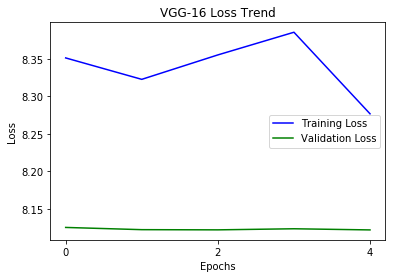

In [75]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

## How'd We Do?

I'm pretty sure I can distinguish a cat from a dog 100% of the time, but how confident is the model?...

Tip: Run on the full dataset with a GPU for a LB logloss of ~0.4 and accuracy at approx 90%. 

In [60]:
# print(predictions)

I am 66.79% sure this is a Cat


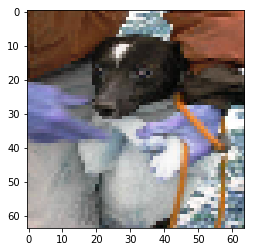

I am 80.02% sure this is a Cat
I am 76.77% sure this is a Cat
I am 74.67% sure this is a Dog
I am 66.29% sure this is a Cat
I am 53.08% sure this is a Cat
I am 51.83% sure this is a Cat
I am 53.16% sure this is a Dog
I am 59.47% sure this is a Cat
I am 56.86% sure this is a Cat
I am 61.00% sure this is a Cat


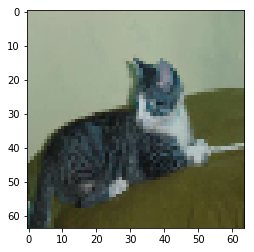

I am 68.51% sure this is a Dog
I am 59.26% sure this is a Dog
I am 52.20% sure this is a Dog
I am 54.99% sure this is a Cat
I am 61.48% sure this is a Dog
I am 63.04% sure this is a Cat
I am 54.99% sure this is a Cat
I am 56.27% sure this is a Cat
I am 51.00% sure this is a Cat
I am 60.34% sure this is a Dog


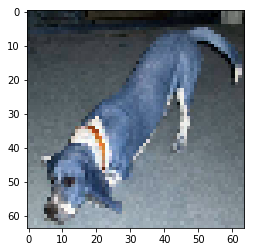

I am 62.21% sure this is a Cat
I am 53.78% sure this is a Cat
I am 66.56% sure this is a Dog
I am 71.97% sure this is a Cat
I am 53.33% sure this is a Dog
I am 68.88% sure this is a Cat
I am 57.59% sure this is a Cat
I am 59.35% sure this is a Cat
I am 52.50% sure this is a Dog
I am 64.91% sure this is a Cat


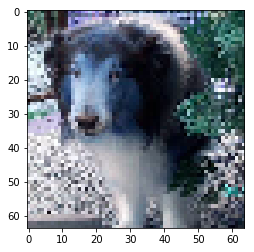

I am 55.14% sure this is a Cat
I am 54.97% sure this is a Dog
I am 66.38% sure this is a Dog
I am 70.78% sure this is a Cat
I am 61.90% sure this is a Dog
I am 61.65% sure this is a Dog
I am 61.74% sure this is a Dog
I am 56.18% sure this is a Dog
I am 63.38% sure this is a Cat
I am 67.40% sure this is a Dog


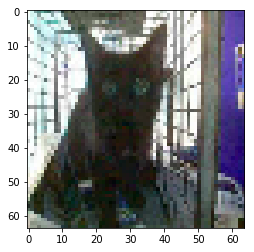

I am 54.83% sure this is a Dog
I am 68.44% sure this is a Dog
I am 52.75% sure this is a Cat
I am 62.84% sure this is a Dog
I am 52.49% sure this is a Cat
I am 61.72% sure this is a Cat
I am 52.49% sure this is a Dog
I am 50.11% sure this is a Cat
I am 56.99% sure this is a Dog
I am 62.26% sure this is a Cat


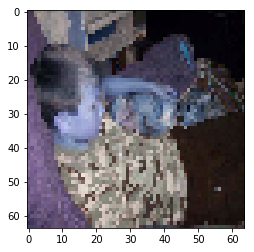

I am 57.20% sure this is a Cat
I am 62.96% sure this is a Cat
I am 51.24% sure this is a Cat
I am 63.07% sure this is a Cat
I am 51.83% sure this is a Cat
I am 60.79% sure this is a Cat
I am 69.44% sure this is a Cat
I am 59.34% sure this is a Cat
I am 72.79% sure this is a Cat
I am 64.01% sure this is a Cat


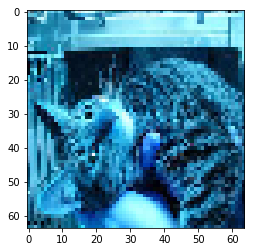

I am 53.09% sure this is a Dog
I am 63.87% sure this is a Dog
I am 62.06% sure this is a Dog
I am 52.08% sure this is a Cat
I am 68.90% sure this is a Cat
I am 67.12% sure this is a Cat
I am 61.01% sure this is a Cat
I am 52.31% sure this is a Dog
I am 68.98% sure this is a Cat
I am 55.98% sure this is a Cat


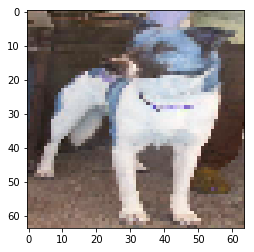

I am 67.39% sure this is a Cat
I am 50.54% sure this is a Dog
I am 58.32% sure this is a Cat
I am 65.59% sure this is a Dog
I am 60.21% sure this is a Cat
I am 52.54% sure this is a Cat
I am 58.14% sure this is a Cat
I am 63.92% sure this is a Cat
I am 58.90% sure this is a Dog
I am 60.14% sure this is a Cat


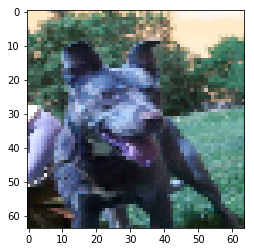

I am 83.79% sure this is a Cat
I am 58.66% sure this is a Cat
I am 74.16% sure this is a Cat
I am 65.93% sure this is a Dog
I am 59.98% sure this is a Cat
I am 51.92% sure this is a Dog
I am 56.07% sure this is a Cat
I am 57.74% sure this is a Dog
I am 67.79% sure this is a Dog
I am 52.74% sure this is a Dog


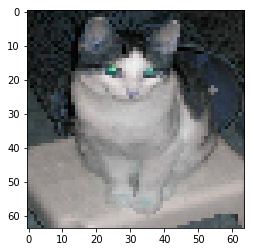

I am 61.33% sure this is a Cat
I am 53.72% sure this is a Cat
I am 53.19% sure this is a Dog
I am 60.21% sure this is a Cat
I am 56.11% sure this is a Cat
I am 68.32% sure this is a Dog
I am 53.22% sure this is a Cat
I am 55.51% sure this is a Dog
I am 66.83% sure this is a Cat


In [61]:
y_pred = []
for i in range(0,predictions.shape[0]):
    if predictions[i, 0] >= 0.5:
        y_pred.append(1)
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        y_pred.append(0)
    if i%10 == 0:
        plt.imshow(test[i])
        plt.show()

In [62]:
assert len(y_pred) == len(y_test),'y_pred != y_test'
count = 0
eid = []
for i in range(len(y_pred)):
    if y_pred[i] == y_test[i]:
        count += 1
    else:
        eid.append(i)
print('accuracy:', count/len(y_pred))

accuracy: 0.63


In [63]:
print(y_pred)

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


In [64]:
print(y_test)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


I am 66.79% sure this is a Cat


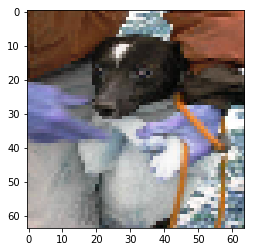

I am 80.02% sure this is a Cat


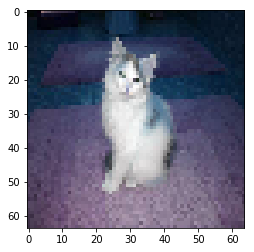

I am 76.77% sure this is a Cat


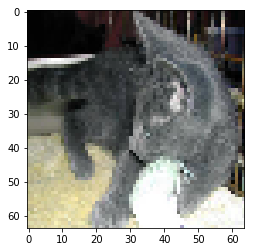

I am 74.67% sure this is a Dog


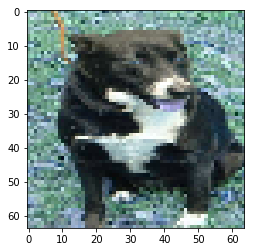

I am 66.29% sure this is a Cat


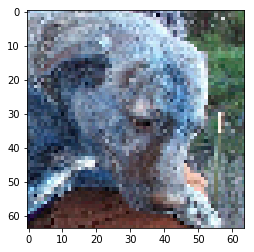

I am 53.08% sure this is a Cat


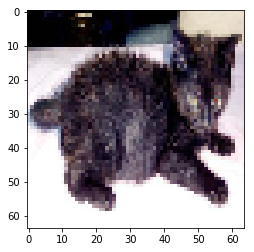

I am 51.83% sure this is a Cat


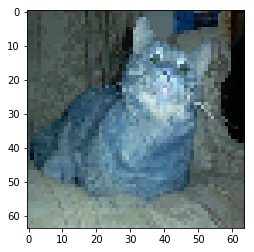

I am 53.16% sure this is a Dog


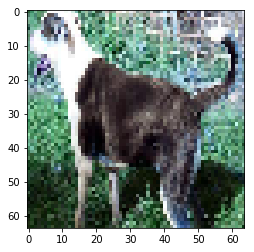

I am 59.47% sure this is a Cat


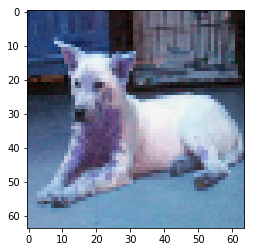

I am 56.86% sure this is a Cat


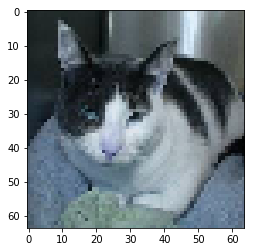

I am 61.00% sure this is a Cat


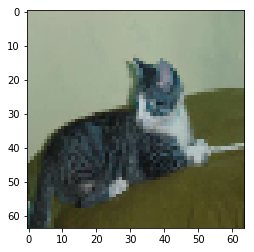

I am 68.51% sure this is a Dog


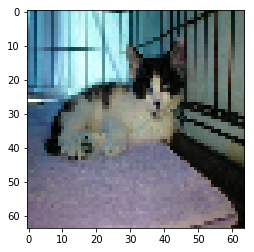

I am 59.26% sure this is a Dog


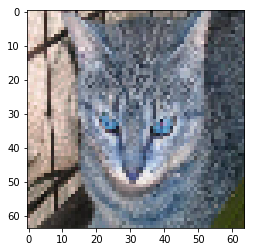

I am 52.20% sure this is a Dog


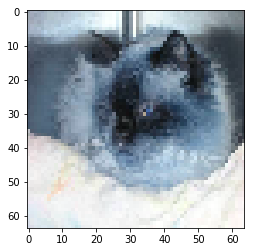

I am 54.99% sure this is a Cat


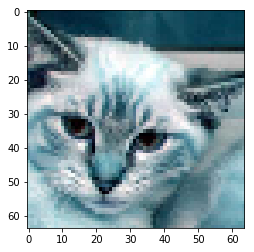

I am 61.48% sure this is a Dog


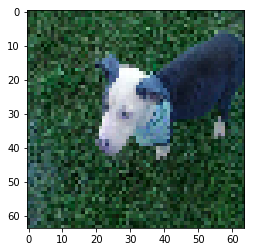

I am 63.04% sure this is a Cat


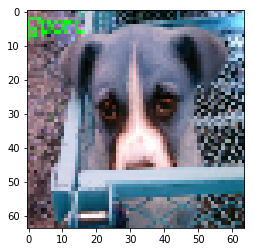

I am 54.99% sure this is a Cat


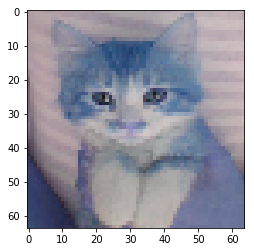

I am 56.27% sure this is a Cat


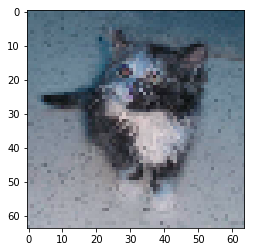

I am 51.00% sure this is a Cat


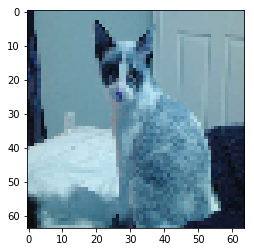

I am 60.34% sure this is a Dog


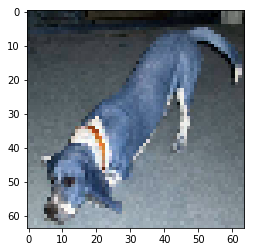

I am 62.21% sure this is a Cat


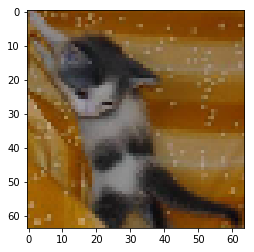

I am 53.78% sure this is a Cat


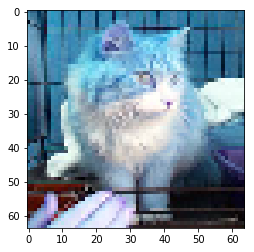

I am 66.56% sure this is a Dog


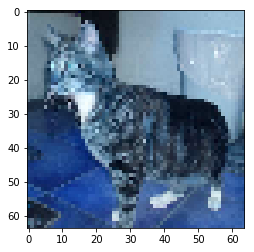

I am 71.97% sure this is a Cat


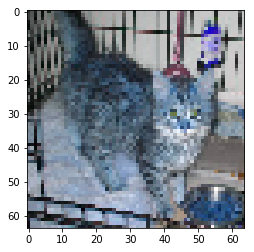

I am 53.33% sure this is a Dog


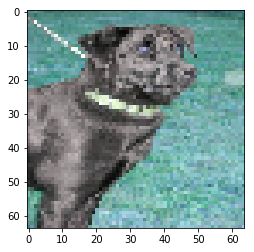

I am 68.88% sure this is a Cat


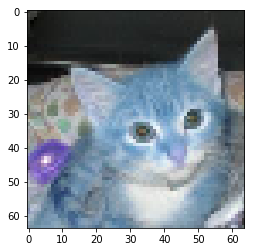

I am 57.59% sure this is a Cat


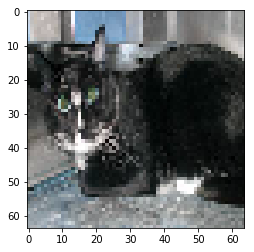

I am 59.35% sure this is a Cat


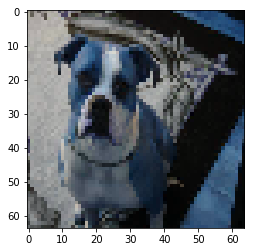

I am 52.50% sure this is a Dog


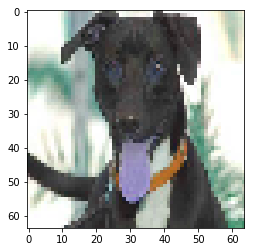

I am 64.91% sure this is a Cat


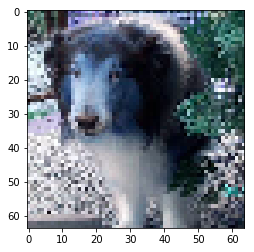

I am 55.14% sure this is a Cat


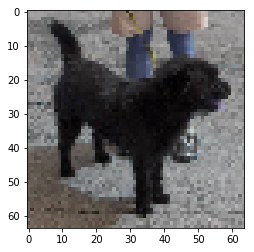

I am 54.97% sure this is a Dog


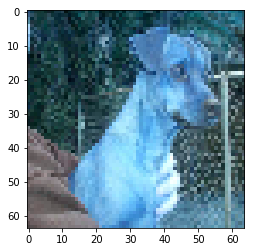

I am 66.38% sure this is a Dog


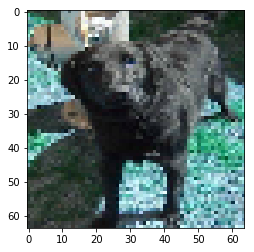

I am 70.78% sure this is a Cat


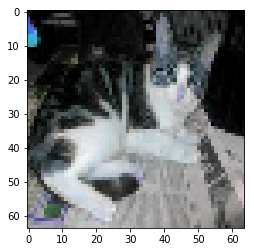

I am 61.90% sure this is a Dog


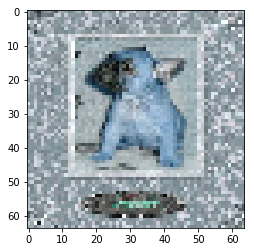

I am 61.65% sure this is a Dog


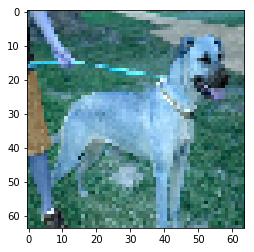

In [65]:
for i in range(len(eid)):
    if predictions[i, 0] >= 0.5:
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
    plt.imshow(test[i])
    plt.show()